<a class="anchor" id="section-one"></a>
## 1. Introduction

We will begin by loading, parsing and displaying the images from the Monet TFRecord file. Note that we won't be using the photo TFRecord file since the DCGAN creates images from scratch.

The next thing we need to do is build the DCGAN model. This involves building two separate neural networks - the generator and the discriminator. We'll go into detail on how these two networks work below.

Finally, we'll create a custom training loop for the model and then we can view our monet-esque art piece!

---

<a class="anchor" id="section-two"></a>
## 2. Get Data

* Load and extract images from monet TFRecord files.
* Display 16 images from the monet dataset in a 4x4 grid.

### Understanding TFRecords:

This section deals with TFRecord files. If you prefer to work with jpeg files, head to the data tab and download the monet_jpg and photo_jpeg files instead.

You may be wondering: what are TFRecord files? They're simply a more efficient way of **storing** and **transferring** data. Each TFRecord file contains multiple data samples (called examples). Each example stores values for certain features.

Let's look at the code below. Since the TFRecord files are stored in a folder, we need to use the **glob module** to access each individual file. We only want files that end with .tfrec. 

Next, TFRecordDataset is used to load these files as bytes. A dictionary is also created to **describe the features**, like image_name and image. After that, we'll create a function that will **parse a single example** from a TFRecord file and extract the data contained inside it. We apply this function to the dataset and shuffle + batch.

Finally, let's create a function to display the images. We convert the monet dataset into an iterable object and retrieve the first item. Then, we use a loop to plot 16 images in a 4x4 grid.

In [1]:
# Import libraries

import matplotlib.pyplot as plt
import numpy as np
import glob

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from keras.layers import BatchNormalization, Dropout
from keras.layers import ReLU, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam

2024-03-03 18:18:08.104852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 18:18:08.104952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 18:18:08.219398: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set the buffer size and batch size

BUFFER_SIZE = 60000
BATCH_SIZE = 32
IMAGE_SIZE = [256, 256]

In [3]:
# Path to all the TFRecord files inside the Monet folders

monet_filepath = glob.glob(f'/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')

In [4]:
# Load TFRecord file from the folder as bytes

raw_monet_dataset = tf.data.TFRecordDataset(monet_filepath)

In [5]:
# Create a dictionary describing the features

feature_description = {
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.string)
}

In [6]:
# Create a function to extract images from the TFRecord file

def _parse_image_function(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_jpeg(example['image'])
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

In [7]:
# Extract images, shuffle and select a batch

monet_dataset = raw_monet_dataset.map(_parse_image_function)
monet_dataset = monet_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
# Create a function to display the 16 images from the dataset

monet_example = next(iter(monet_dataset))

def display_images(example):
    plt.figure(figsize = (7, 7))
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(example[n] * 0.5 + 0.5)
        plt.axis("off")

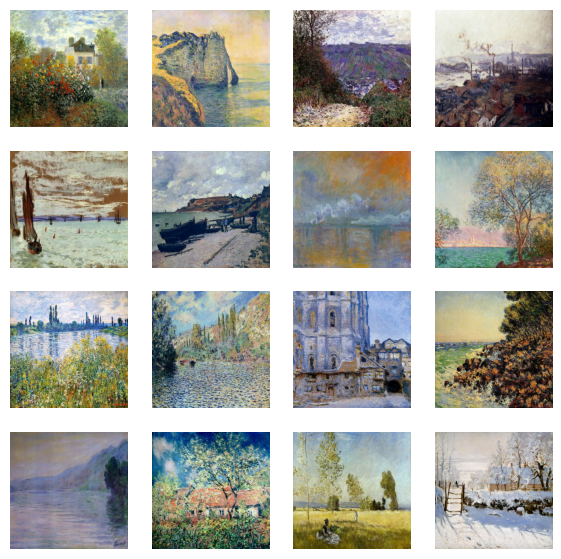

In [9]:
# Display the first 16 images from the monet dataset

display_images(monet_example)

---

<a class="anchor" id="section-three"></a>
## 3. Build Model

* Build the generator that takes a noise vector and outputs a tensor of 256x256x3.
* Build the discriminator that takes the tensor of 256x256x3 and outputs a probability that an image is real or fake.
* Create two separate loss functions and optimizers for the generator and discriminator.

<div align="center">
    <img src="https://raw.githubusercontent.com/justinsiowqi/-Paint-With-DCGAN/main/GAN%20diagram.png" alt="GAN Diagram" style="width: 500px;"> 
</div>
<div align="center">
  GAN Architecture (source: GANs in Action)
</div>

### An Overview on GANs:

GANs are a type of machine learning algorithm that uses two neural networks to generate new data. The two networks **play a game** against each other. The generator's goal is to **produce fake data**, while the discriminator's goal is to **tell fake data apart from real data**. 

You can imagine the generator to be a con-artist that forges paintings and resells them for a living. On the other hand, the discriminator is a museum purveyor who purchases art pieces for his gallery. 

Let's take a look at the diagram above. The generator uses the random noise vector (z) to produce a bunch of fake images (x*). The discriminator is also given a bunch of real images (x) from the training set. The discriminator must now decide which is real and fake. This process is repeated many times until the generator gets really good at producing fake images, whereas the disriminator gets better at distinguishing real from fake. 

<a class="anchor" id="section-three-one"></a>
### 3.1. Build the Generator

<div align="center">
    <img src="https://raw.githubusercontent.com/justinsiowqi/-Paint-With-DCGAN/main/DCGAN%20Generator%20diagram.png" alt="DCGAN Generator Diagram" style="width: 500px;"> 
</div>
<div align="center">
  DCGAN Generator (source: GANs in Action)
</div>

### An Overview on the Generator:

We will start by defining a function called build_generator which uses the **Sequential API** to stack layers.

The generator takes in a random noise vector as input and reshapes it into a 8x8x1024 tensor through a fully connected layer. 

We use **transposed convolutions** to reshape tensors until we get a tensor output of 256x256x3. Transposed convolutions upsizes a vetor into an image by **increasing the height and width** and **decreasing the depth**.

Between the transposed convolution layers, we applied **batch normalization** to stabilize the process. After batch normalization, the **ReLU** activation function is applied to help gradients flow through properly. 

As for the final layer, we do not apply batch normalization. We also use the **tanh** activation function instead of leaky ReLU.

In [10]:
# Create a function to build the generator model

def build_generator():
    model = Sequential()
    model.add(Dense(8*8*1024, input_shape=(100,)))
    model.add(Reshape((8, 8, 1024)))

    model.add(Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('tanh'))

    return model

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


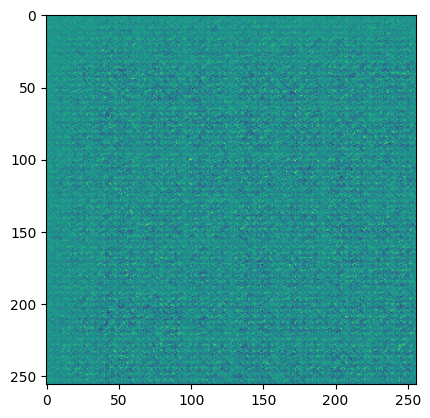

In [11]:
# Use the noise vector to create an image. The generator is still untrained here!

generator = build_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

<a class="anchor" id="section-three-two"></a>
### 3.2. Build the Discriminator

<div align="center">
    <img src="https://raw.githubusercontent.com/justinsiowqi/-Paint-With-DCGAN/main/DCGAN%20Discriminator%20Diagram.png" alt="DCGAN Discriminator Diagram" style="width: 500px;"> 
</div>
<div align="center">
  DCGAN Discriminator (source: GANs in Action)
</div>

### An Overview on the Discriminator:

Now that we've finished the generator, we can move on to the discriminator. You'll find that this is oddly similar to a regular classifier.

Let's begin by creating a function called build_discriminator and using the **Sequential API**.

The discriminator receives the 256x256x3 image as input from the generator. 

Next, we apply several **convolutional layers** to downsize the image. Convolutional layers are like transposed convolutional layers but it works in reverse: they **decrease the height and width** and **increase the depth**.

Also, we apply **batch normalization**, **leaky ReLU** activation function and **dropout** after each convolutional layer. Take note that the very first layer does not have batch normalization.

The final layer is a fully connected layer that uses a **sigmoid** activation function and outputs the probability that an image is real rather than fake.

In [12]:
# Create a function to build the discriminator model

def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', input_shape=[256, 256, 3]))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    return model

In [13]:
# Use the discriminator to classify the image above (1 for real and 0 for fake)

discriminator = build_discriminator()
decision = discriminator(generated_image)
print (decision)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


tf.Tensor([[0.5000081]], shape=(1, 1), dtype=float32)


<a class="anchor" id="section-three-three"></a>
### 3.3. Define Loss Functions & Optimizers

* Create two separate loss functions
    * The generator performs well when the discriminator outputs 1 for a fake image.
    * The discriminator performs well when it outputs 1 for a real image and 0 for a fake image.
* Create two separate optimzers
    * Both models use an Adam optimizer with learning rate of 0.0001 and beta of 0.5

In [14]:
# Create two separate loss functions for the generator and discriminator

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [15]:
# Create two separate optimizers for the generator and discriminator

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00015, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

---

<a class="anchor" id="section-five"></a>
## 4. Train Model

* Create a custom training loop that trains the models and compute the losses.
* Create a function to display the sampled images in a 4x4 grid.

<a class="anchor" id="section-four-one"></a>
### 4.1. Custom Training Loop

### An Overview on Custom Training Loops

In some cases, the regular fit() method is simply not flexible enough. Since we're using separate loss functions and optimizers for the generator and discriminator, it's best that we create a custom training loop.

Training the GAN requires a **ton** of trial and error so feel free to play around with the hyperparameters here!

There are two functions we need to create. The first function trains **one step** of a GAN. The generator uses the random noise vector to generate a bunch of images. The discriminator evaluates both the real and fake images. We compute the generator and discriminator loss using the loss functions we created earlier. Finally, we update the optimizers and return the losses for both models.

The second function involves training the GAN on **multiple epochs**. For each epoch, we will loop through the image batches and calculate the losses. Finally, we will output one sample image every 25 epochs (250 epochs / 25 sample interval).

In [16]:
# Set the hyperparameters to be used for training

EPOCHS = 500
noise_dim = 100
sample_interval = EPOCHS / 10
num_examples_to_generate = 16

In [17]:
# Create a function that trains one step of a GAN

@tf.function
def train_step(images):
    
    # Create random noise vect
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # Use random noise vector to generate images
        generated_images = generator(noise, training=True)

        # Discriminator evaluates the real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Losses are computed for both the generator and discriminator
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update optimizers
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [18]:
# Create a function that trains the GAN on multiple epochs

def train(dataset, epochs):
    
    for epoch in range(epochs):
        
        # Create an empty list to store losses 
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])
            
            # Calculate total loss 
            g_loss = sum(gen_loss_list) / len(gen_loss_list)
            d_loss = sum(disc_loss_list) / len(disc_loss_list)

        print (f'Epoch {epoch + 1} [G loss: {g_loss}] [D loss: {d_loss}]')
        
        # For every 25 epochs, we will output an image
        if (epoch + 1) % sample_interval == 0:
            sample_images(generator)

<a class="anchor" id="section-four-two"></a>
### 4.2. Sample & Display Images

* We use the sampled random noise vectors to generate the images, then we rescale the images to [0, 1].
* Finally, we plot the images in a 4x4 grid.

In [19]:
# Create a function to plot the generated images from the GAN model

def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise vector
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Generate images
    gen_imgs = generator.predict(noise)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set grid and plot images
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(7, 7), sharey=True, sharex=True)

    count = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[count, :, :, :])
            axs[i, j].axis('off')
            count += 1

/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:669: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-03-03 18:18:31.640421: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1 [G loss: 1.083191156387329] [D loss: 1.4897115230560303]
Epoch 2 [G loss: 1.3762385845184326] [D loss: 1.053344488143921]
Epoch 3 [G loss: 1.4963897466659546] [D loss: 1.2120054960250854]
Epoch 4 [G loss: 1.5231506824493408] [D loss: 1.1153948307037354]
Epoch 5 [G loss: 1.6698335409164429] [D loss: 1.07566237449646]
Epoch 6 [G loss: 1.6007457971572876] [D loss: 1.1423134803771973]
Epoch 7 [G loss: 1.5700023174285889] [D loss: 1.162161111831665]
Epoch 8 [G loss: 1.9882919788360596] [D loss: 0.947722315788269]
Epoch 9 [G loss: 1.8432016372680664] [D loss: 1.155579686164856]
Epoch 10 [G loss: 1.8511180877685547] [D loss: 1.1945409774780273]
Epoch 11 [G loss: 1.8197135925292969] [D loss: 1.0357544422149658]
Epoch 12 [G loss: 2.1350879669189453] [D loss: 0.7134866714477539]
Epoch 13 [G loss: 2.0743815898895264] [D loss: 0.6440349817276001]
Epoch 14 [G loss: 2.6195340156555176] [D loss: 0.9343668222427368]
Epoch 15 [G loss: 2.122755289077759] [D loss: 0.8326300382614136]
Epoch 16 [G 

I0000 00:00:1709490141.688832      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 51 [G loss: 1.9494167566299438] [D loss: 1.1328990459442139]
Epoch 52 [G loss: 2.1130566596984863] [D loss: 1.4447914361953735]
Epoch 53 [G loss: 1.7810274362564087] [D loss: 1.7530581951141357]
Epoch 54 [G loss: 1.8254410028457642] [D loss: 1.3131707906723022]
Epoch 55 [G loss: 1.633771538734436] [D loss: 1.2943909168243408]
Epoch 56 [G loss: 1.7890046834945679] [D loss: 1.028119683265686]
Epoch 57 [G loss: 1.846716284751892] [D loss: 1.1272779703140259]
Epoch 58 [G loss: 1.8227431774139404] [D loss: 1.3053748607635498]
Epoch 59 [G loss: 2.1172213554382324] [D loss: 1.0236538648605347]
Epoch 60 [G loss: 1.6427795886993408] [D loss: 0.9673748016357422]
Epoch 61 [G loss: 1.8367410898208618] [D loss: 1.2011175155639648]
Epoch 62 [G loss: 1.9144270420074463] [D loss: 0.9592119455337524]
Epoch 63 [G loss: 1.8919757604599] [D loss: 0.9712796211242676]
Epoch 64 [G loss: 1.8436084985733032] [D loss: 1.0994817018508911]
Epoch 65 [G loss: 1.8633317947387695] [D loss: 1.125268578529358]
Ep

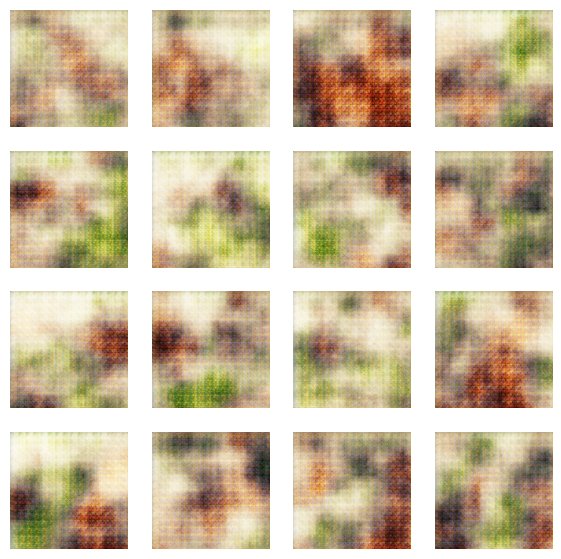

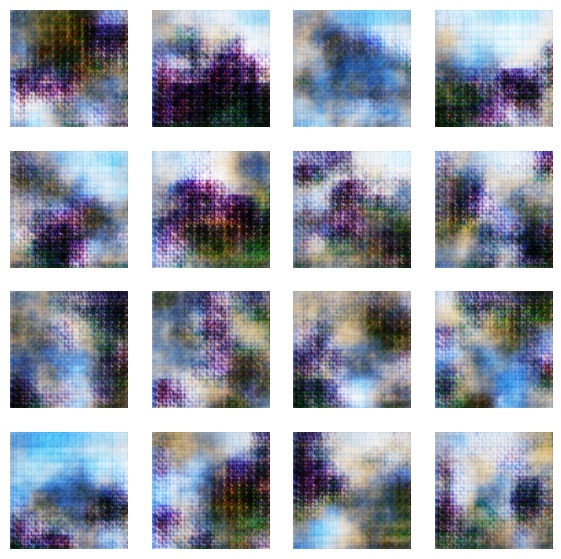

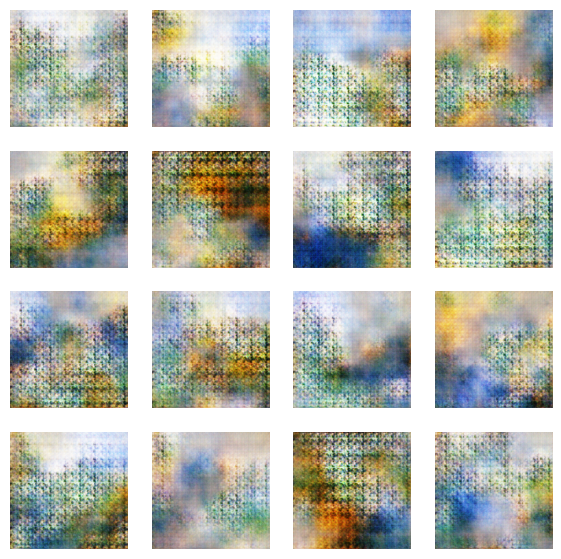

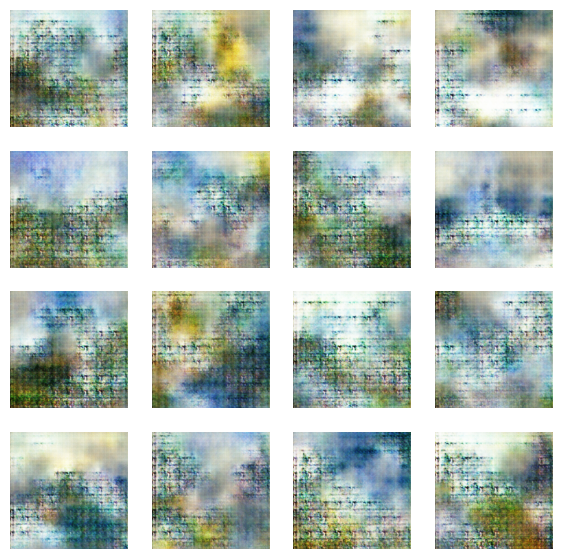

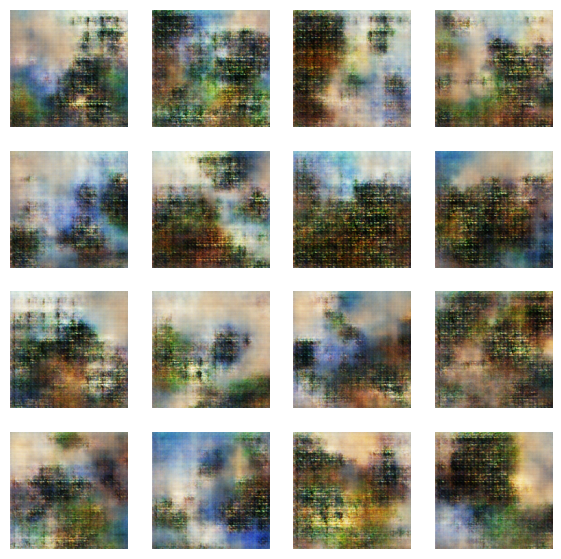

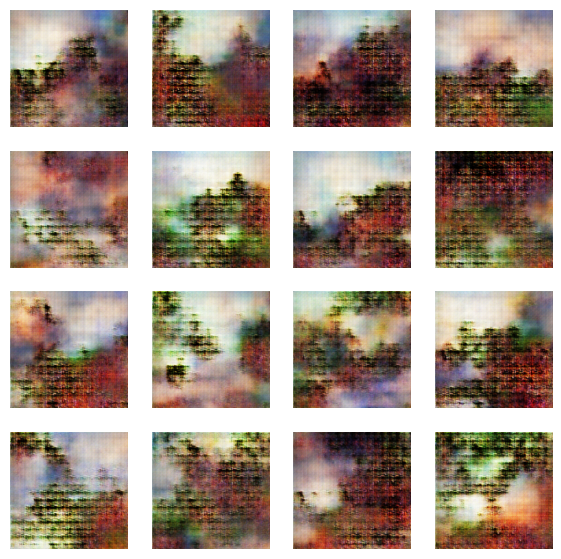

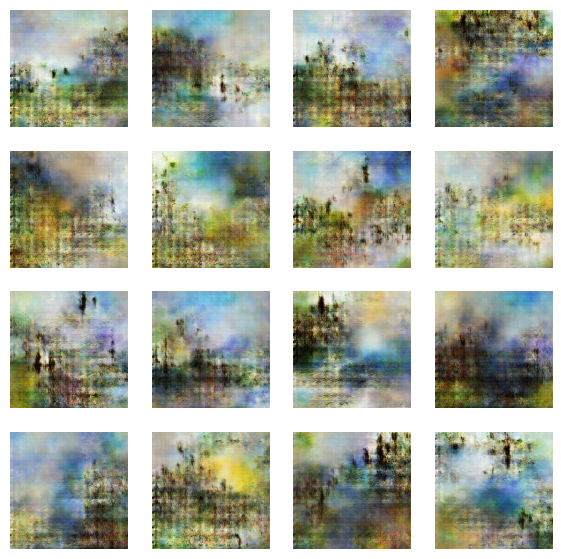

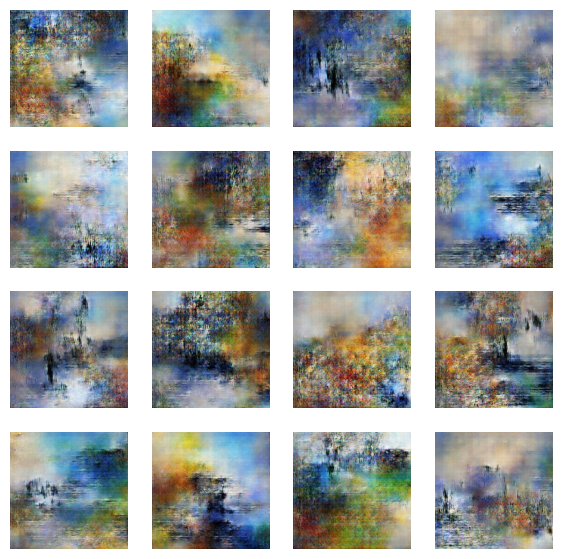

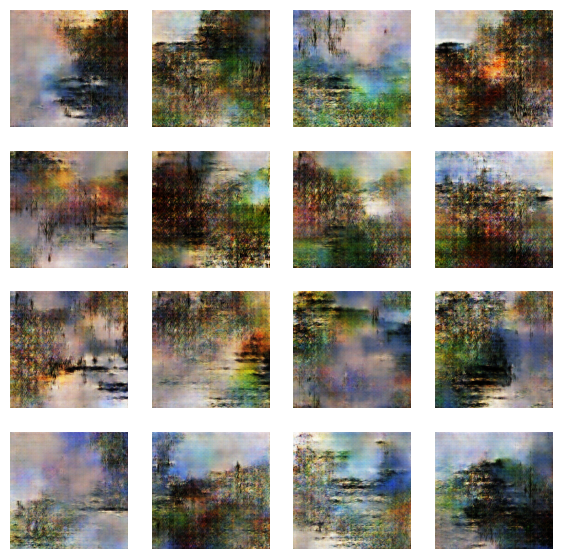

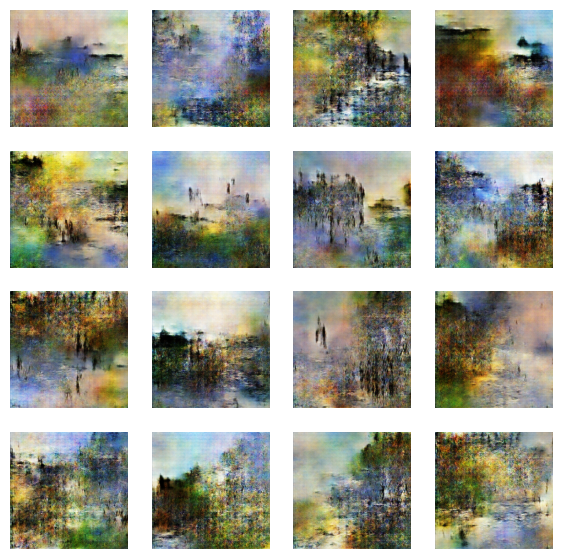

In [20]:
train(monet_dataset, EPOCHS)

---

<a class="anchor" id="section-six"></a>
## 6. Submit Images

In [21]:
# Import libraries

import os
from PIL import Image
import shutil

In [ ]:
# Create new directory and generate images

image_dir =  '/kaggle/working/images'
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

for i in range(7000):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    submission_imgs = generator.predict(noise)
    submission_imgs = 0.5 * submission_imgs + 0.5
    submission_imgs = (submission_imgs * 255).astype('uint8')
    submission = Image.fromarray(submission_imgs[0, :, :, :])
    submission.save(f"/kaggle/working/images/images_{i}.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [24]:
# Create a zip file of the images

shutil.make_archive('images', 'zip', 'images')

'/kaggle/working/images.zip'

<a class="anchor" id="section-seven"></a>
## 7. Conclusion

I hope you enjoyed learning how to create these Monet-esque paintings! 

Here's a quick summary of what we learnt today. We started off by parsing and extracting images from a TFRecord file. Then, we learnt that GANs are simply made of two separate models: the generator and the discriminator. The former creates fake images, while the latter attempts to tell apart those fake images from real images from the training set. We built both models step-by-step and created the separate loss functions and optimizers. Lastly, we learnt how to flexibly train a GAN model through a custom training loop. 

If you have any questions or feedback, feel free to reach out in the comments section. Also, don't hesitate to upvote and drop a follow when you can. Have a great week ahead!

### References:

* [A Hands-On Guide to TFRecords](https://towardsdatascience.com/a-practical-guide-to-tfrecords-584536bc786c)
* [Write the TFRecord File](https://www.tensorflow.org/tutorials/load_data/tfrecord#write_the_tfrecord_file)
* [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan?hl=en)
* [Monitor GAN Training Progress and Identify Common Failure Modes](https://www.mathworks.com/help/deeplearning/ug/monitor-gan-training-progress-and-identify-common-failure-modes.html)
* [Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)

# Github

https://github.com/panta96pranav/GANs